# import

In [31]:
import copy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.affinity import affine_transform
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, box
from geopandas import GeoSeries, GeoDataFrame
from shapely.ops import split, unary_union, polygonize
import pickle

# read data

In [2]:
gdf_land = gpd.read_file('land.shp')
gdf_land.crs = None
gdf_main_road = gpd.read_file('mainroad.shp')
gdf_main_road.crs = None
gdf_road = gpd.read_file('line.shp')
gdf_road.crs = None


gdf_main_road['type'] = 'main_road'
gdf_road['type'] = 'road'
gdf_combined = pd.concat([gdf_main_road, gdf_road])

# translate, rescale, obtain intersections

In [3]:
def translate_and_rescale(gdf):
    # Get the minimum x and y values from total_bounds
    x_min, y_min, x_max, y_max = gdf.total_bounds
    
    # Calculate the translation values
    x_translation = -x_min
    y_translation = -y_min
    
    # Apply the translation to the GeoDataFrame
    gdf['geometry'] = gdf.translate(xoff=x_translation, yoff=y_translation)
    
    scaling_factor = 0.1  # Scale down by a factor of 10
    
    # Create the scaling matrix
    scaling_matrix = [scaling_factor, 0, 0, scaling_factor, 0, 0]
    
    # Apply the scaling transformation to the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: affine_transform(geom, scaling_matrix))

    return gdf

In [4]:
gdf_land = translate_and_rescale(gdf_land)
gdf_combined = translate_and_rescale(gdf_combined)
gdf_road = gdf_combined[gdf_combined['type']=='road'].copy()
gdf_main_road = gdf_combined[gdf_combined['type']=='main_road'].copy()

In [5]:
def explode_lines(gdf_road):
    # Create or load the GeoDataFrame gdf_road
    # For this example, let's assume you have a GeoDataFrame named gdf_road
    
    # Define a tolerance value for simplification (adjust as needed)
    tolerance = 0.1  # You can adjust this value based on your dataset and needs
    
    # Apply the simplify operation to the 'geometry' column
    gdf_road['geometry'] = gdf_road['geometry'].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True) if geom.geom_type == 'LineString' else geom)
    
    
    # Define a function to extract coordinates from LineString and convert to Points
    def extract_coordinates_to_points(line):
        return [Point(coord) for coord in line.coords]
    
    # Apply the function to create a new 'points' column
    gdf_road['points'] = gdf_road['geometry'].apply(extract_coordinates_to_points)
    
    # Explode the 'points' column to create a new GeoDataFrame with points
    gdf_points = gdf_road.explode('points')
    
    # Merge LineString and Point geometries into a single 'geometry' column
    gdf_points['geometry'] = gdf_points['points']
    gdf_points = gdf_points.drop('points', axis=1)
    
    # Create a set to store unique integer nodes
    unique_nodes = set()
    
    # Function to approximate coordinates of a point to integers
    def approximate_to_integers(point):
        return Point(int(point.x), int(point.y))
    
    # Iterate through the 'geometry' column and add unique integer nodes to the set
    for geom in gdf_points['geometry']:
        if geom.geom_type == 'Point':
            integer_node = approximate_to_integers(geom)
            unique_nodes.add(integer_node)
    
    # Create a GeoDataFrame from the set of unique integer nodes
    simplified_gdf_points = gpd.GeoDataFrame(geometry=list(unique_nodes), crs=gdf_points.crs)
    
    gdf_road = gdf_road.drop('points', axis=1)
    
    # Combine the original GeoDataFrame 'gdf_road' with 'gdf_points'
    gdf = pd.concat([gdf_road, simplified_gdf_points], ignore_index=True)
    
    # Now, add the 'x' and 'y' columns
    gdf['x'] = gdf['geometry'].apply(lambda geom: geom.x if geom.geom_type == 'Point' else None)
    gdf['y'] = gdf['geometry'].apply(lambda geom: geom.y if geom.geom_type == 'Point' else None)
    return gdf

In [6]:
gdf_main_road_exploded = explode_lines(gdf_main_road)
gdf_road_exploded = explode_lines(gdf_road)
gdf_main_road_exploded['type'] = 'main_road'
gdf_road_exploded['type'] = 'road'
gdf_combined = pd.concat([gdf_main_road_exploded, gdf_road_exploded])

# visualization

In [7]:
def plot_gdf(gdf, filename=None, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    gdf.plot(ax=ax, linewidth=2, markersize=15, **kwargs)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

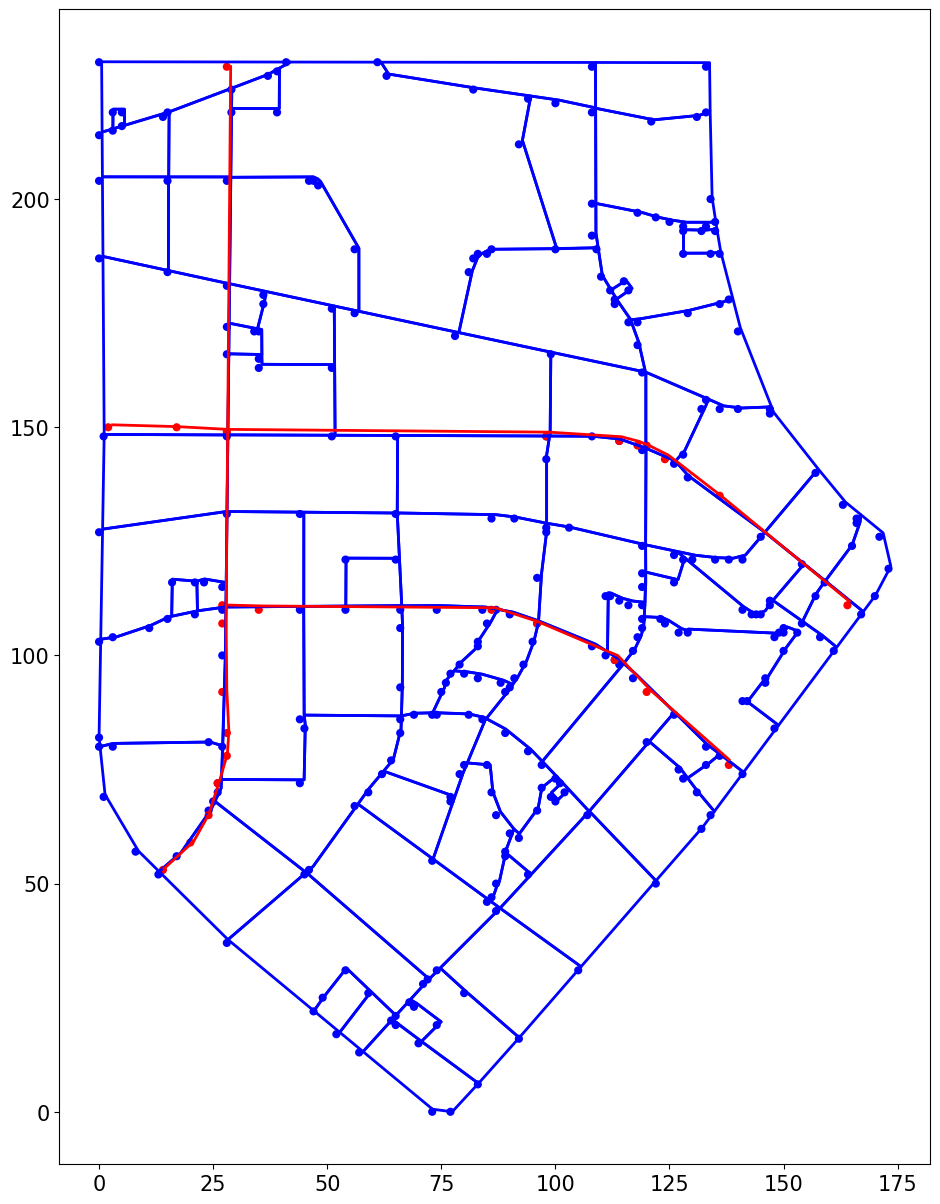

In [8]:
color_dict = {
    'main_road': 'red',
    'road': 'blue'
}
gdf_combined = gdf_combined.sort_values(by='type', ascending=False)
plot_gdf(gdf_combined, color=gdf_combined['type'].apply(lambda x: color_dict[x]), categorical=True, k=2, filename='roads.pdf')

In [9]:
# Use the .explore() method to visualize the GeoDataFrame with colors based on the 'type' column
gdf_combined = gdf_combined.sort_values(by='type', ascending=False)
gdf_combined.explore(column='type', cmap=['red', 'blue'], categorical=True, k=2)

# generate initial plan

## annotate the map manually
<div style="display: flex; justify-content: center;">
    <img src="roads_annotated_v2.jpeg" width="45%" style="margin-right: 5px;">
    <img src="roads_simplified_v2.jpeg" width="45%">
</div)

## obtain simplified road segments

In [12]:
roads = [
    LineString([(0, 230), (0, 86), (13, 52)]), # 银湖路
    LineString([(13, 52), (28, 37), (52, 17), (57, 13), (75, 0)]), # 银岭路
    LineString([(0, 230), (135, 230)]), # 横一路
    LineString([(135, 230), (135, 177), (147, 153), (157, 140), (175, 124)]), # 惠河高速公路
    LineString([(175, 124), (167, 109), (141, 74), (134, 65), (122, 50), (105, 31), (92, 16), (83, 6), (75, 0)]), #仲恺大道
    LineString([(29, 230), (29, 72), (13, 52)]), # 陈江大道
    LineString([(0, 148), (120, 148), (147, 127), (167, 109)]), # 五一大道
    LineString([(0, 127), (128, 127), (147, 127), (157, 140)]), #泄洪渠
    LineString([(0, 110), (98, 110), (114, 98), (126, 87), (133, 80), (141, 74)]), # 体育路
    LineString([(0, 86), (84, 86), (97, 76), (107, 65), (122, 50)]), # 胜利路
    LineString([(0, 204), (50, 204), (50, 176), (50, 148)]), # A
    LineString([(0, 187), (29, 181), (50, 176), (78, 170), (98, 166), (120, 162), (147, 153)]), # 五一村道
    LineString([(44, 127), (44, 72), (29, 72)]), # B
    LineString([(66, 148), (66, 86), (56, 67), (46, 53), (28, 37)]), # C
    LineString([(98, 166), (98, 110), (84, 86), (73, 55)]), # D
    LineString([(108, 230), (108, 189), (116, 173), (120, 162), (120, 118), (120, 110), (114, 98), (97, 76)]), # E
    LineString([(126, 87), (119, 78), (107, 65), (87, 44), (72, 29), (68, 24), (65, 21), (57, 13)]), # F
    LineString([(94, 217), (94, 189)]), # G
    LineString([(0, 214), (29, 224), (41, 230)]), # H-1
    LineString([(61, 230), (94, 217), (135, 217)]), #H-2
    LineString([(78, 170), (83, 189), (108, 189)]), # I-1
    LineString([(108, 199), (135, 199)]), #I-2
    LineString([(116, 173), (135, 177)]), # I-3
    LineString([(119,78), (128, 73), (134, 65)]), # J
    LineString([(56, 67), (73, 55), (87, 44), (105, 31)]), # K
    LineString([(29, 72), (46, 53), (72, 29), (92, 16)]), #L
    LineString([(52, 17), (59, 26), (65, 21), (70, 15), (83, 6)]), #S3-S4-1
    LineString([(68, 24), (74, 19), (70, 15)]), #S3-S4-2
    LineString([(133, 80), (128, 73)]), #S3-S4-3
    LineString([(120, 118), (128, 118), (128, 127)]), #S3-S4-4
]

In [13]:
def aggregate(lines):
    line = lines[0]
    for var in range(1, len(lines)):
        line = split(line, lines[var])
        if len(line.geoms) > 1:
            line = MultiLineString(line)
        else:
            line = line.geoms[0]
        new_line = split(lines[var], line)
        if len(new_line.geoms) > 1:
            new_line = MultiLineString(new_line)
        else:
            new_line = new_line.geoms[0]
        line = line.union(new_line)
    temp_roads = list(line.geoms)
    roads = []
    for road in temp_roads:
        if len(road.coords) == 2:
            roads.append(road)
        elif len(road.coords) > 2:
            divided_roads = [LineString([road.coords[i], road.coords[i+1]]) for i in range(len(road.coords) - 1)]
            roads.extend(divided_roads)
        else:
            raise RuntimeError('Number of segments fault!')
    roads_type = [2 for _ in range(len(roads))]
    intersections = []
    for road in roads:
        intersections.append(Point(road.coords[0]))
        intersections.append(Point(road.coords[1]))
    intersections = list(unary_union(intersections).geoms)
    intersections_type = [14 for _ in range(len(intersections))]
    feasibles = list(polygonize(roads))
    feasibles_type = [1 for _ in range(len(feasibles))]
    types = roads_type + intersections_type + feasibles_type
    geometries = roads + intersections + feasibles
    gdf = GeoDataFrame({'id': list(range(len(types))),
                        'type': types,
                        'existence': [True for _ in range(len(types))],
                        'geometry': geometries}).set_index('id')
    return gdf

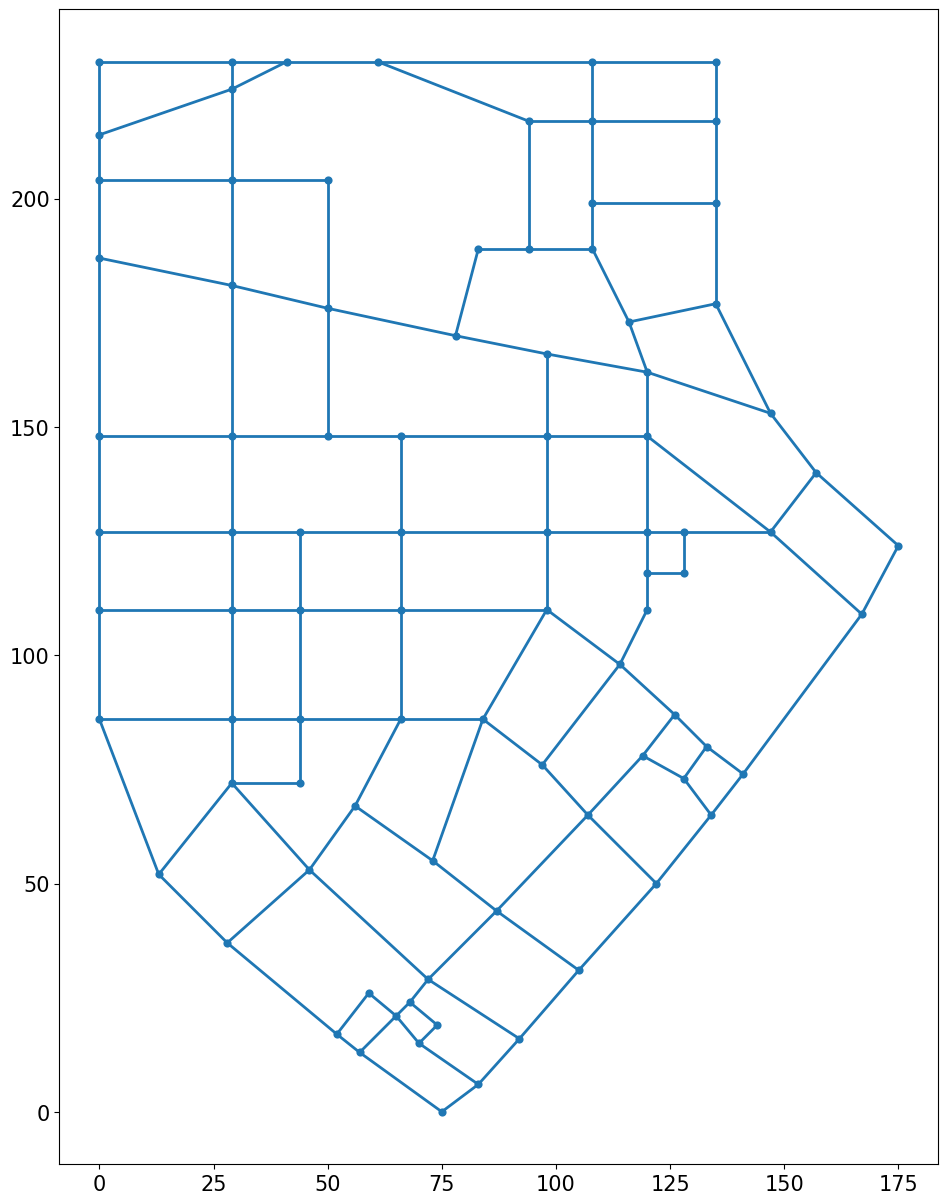

In [14]:
gdf_simplified = aggregate(roads)
plot_gdf(gdf_simplified[gdf_simplified.geom_type!='Polygon'])

In [15]:
print(len(gdf_simplified[gdf_simplified.geom_type=='LineString']))
print(len(gdf_simplified[gdf_simplified.geom_type=='Point']))
print(len(gdf_simplified[gdf_simplified.geom_type=='Polygon']))

141
88
54


In [16]:
gdf_road_simplified = gdf_simplified[gdf_simplified.geom_type!='Polygon']
gdf_road_simplified.explore()

## compare simplified and original roads

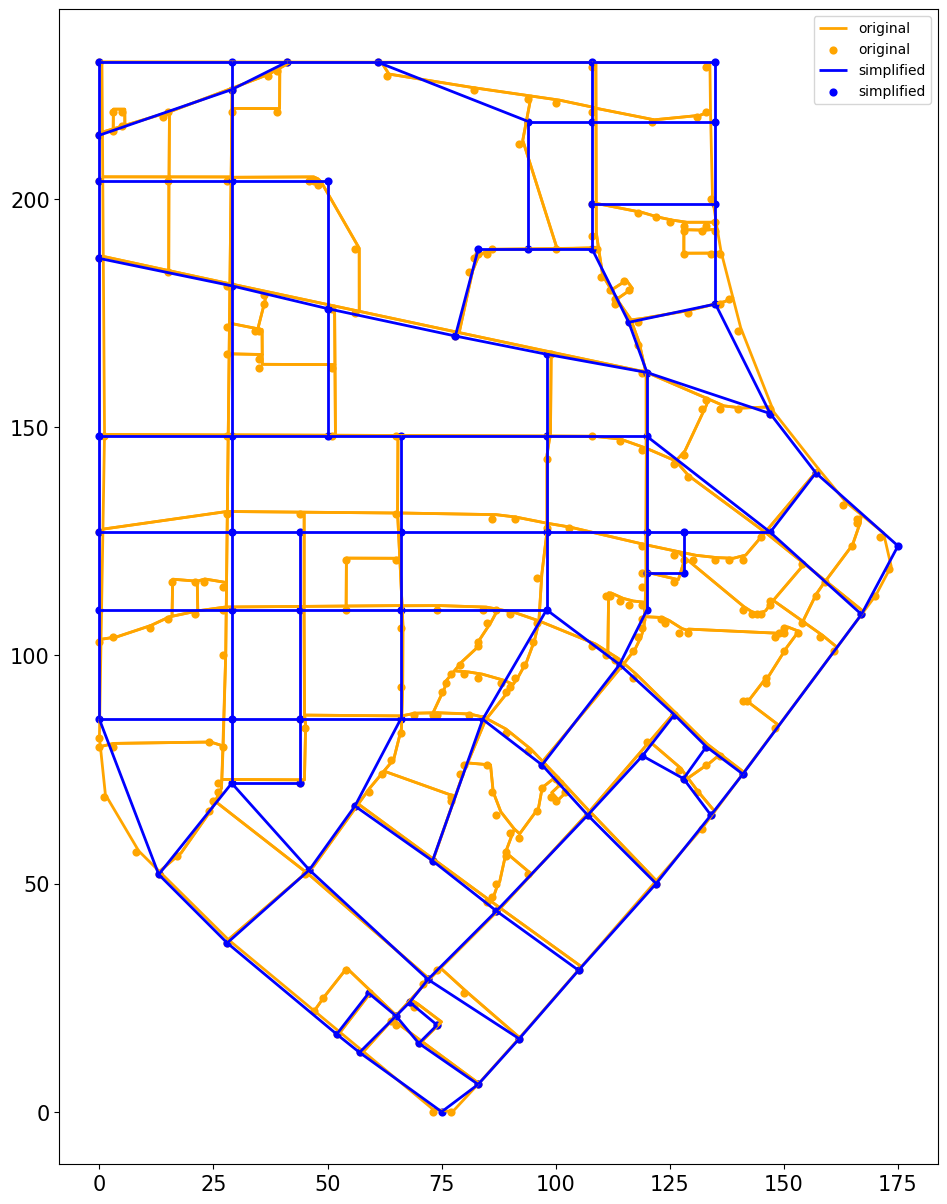

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
gdf_road_exploded.plot(ax=ax, linewidth=2, markersize=15, color='orange', label='original')
gdf_road_simplified.plot(ax=ax, linewidth=2, markersize=15, color='blue', label='simplified')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.show()

## initial land use conditions

In [19]:
gdf_simplified.explore()

In [27]:
NON_BLOCK_LAND_USE = (
    'outside',
    'feasible',
    'road',
    'boundary'
)

BLOCK_LAND_USE = (
    'residential',
    'business',
    'office',
    'green_l',
    'green_s',
    'school',
    'hospital_l',
    'hospital_s',
    'recreation',
    'residential_extra'
)

LAND_USE = (
    NON_BLOCK_LAND_USE + BLOCK_LAND_USE)

OUTSIDE = 0
FEASIBLE = 1
ROAD = 2
BOUNDARY = 3
RESIDENTIAL = 4
BUSINESS = 5
OFFICE = 6
GREEN_L = 7
GREEN_S = 8
SCHOOL = 9
HOSPITAL_L = 10
HOSPITAL_S = 11
RECREATION = 12
RESIDENTIAL_EXTRA = 13

LAND_USE_ID = (
    OUTSIDE,
    FEASIBLE,
    ROAD,
    BOUNDARY,
    RESIDENTIAL,
    BUSINESS,
    OFFICE,
    GREEN_L,
    GREEN_S,
    SCHOOL,
    HOSPITAL_L,
    HOSPITAL_S,
    RECREATION,
    RESIDENTIAL_EXTRA
)

NUM_TYPES = len(LAND_USE_ID)

LAND_USE_ID_MAP = dict(
    zip(LAND_USE, LAND_USE_ID))

LAND_USE_ID_MAP_INV = dict(
    zip(LAND_USE_ID, LAND_USE))

INTERSECTION = 14

In [20]:
# input land use
residential_ids = [232, 233, 235, 236, 242, 256, 262, 265, 248, 263, 264, 272, 277, 276]
business_ids = [229]
school_ids = [281]
office_ids = []
green_l_ids = []
green_s_ids = [241, 243]
hospital_l_ids = [282]
hospital_s_ids = [239, 275, 270]
outside_ids = [271, 244]
gdf_simplified.loc[residential_ids, 'type'] = 4
gdf_simplified.loc[business_ids, 'type'] = 5
gdf_simplified.loc[school_ids, 'type'] = 9
gdf_simplified.loc[office_ids, 'type'] = 6
gdf_simplified.loc[green_l_ids, 'type'] = 7
gdf_simplified.loc[green_s_ids, 'type'] = 8
gdf_simplified.loc[outside_ids, 'type'] = 0
gdf_simplified.loc[hospital_l_ids, 'type'] = 10
gdf_simplified.loc[hospital_s_ids, 'type'] = 11

In [21]:
print(gdf_simplified.area.sum())
print(gdf_simplified.unary_union.bounds)

28862.0
(0.0, 0.0, 175.0, 230.0)


## visualize

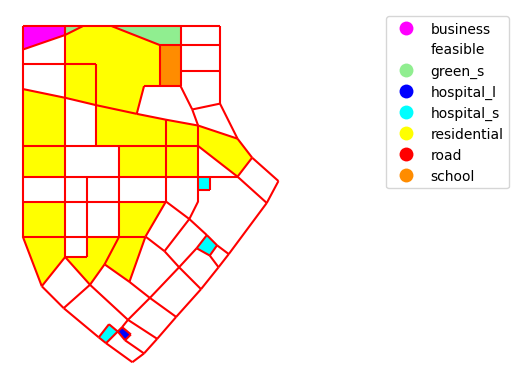

In [39]:
TYPE_COLOR_MAP = {
    'boundary': 'lightgreen',
    'business': 'fuchsia',
    'feasible': 'white',
    'green_l': 'green',
    'green_s': 'lightgreen',
    'hospital_l': 'blue',
    'hospital_s': 'cyan',
    'office': 'gold',
    'outside': 'black',
    'residential': 'yellow',
    'road': 'red',
    'school': 'darkorange',
    'recreation': 'lavender',
    'residential_extra': 'lightyellow',
}

gdf_viz = copy.deepcopy(gdf_simplified[(gdf_simplified['existence'] == True) &
                                          (gdf_simplified['type'] != OUTSIDE) &
                                          (gdf_simplified['type'] != BOUNDARY) &
                                          (gdf_simplified['type'] != INTERSECTION)])
gdf_viz['legend'] = gdf_viz['type'].apply(lambda x: LAND_USE_ID_MAP_INV[x])
#gdf_viz = gdf_viz[gdf_viz.geom_type=='Polygon']
existing_types = sorted([LAND_USE_ID_MAP_INV[var] for var in gdf_viz['type'].unique()])
cmap = ListedColormap(
    [TYPE_COLOR_MAP[var] for var in existing_types])
gdf_viz.plot(
    'legend',
    cmap=cmap,
    categorical=True,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.8, 1)}
)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [40]:
d = dict()
d['gdf'] = gdf_simplified
with open('./init_plan_huizhou.pickle', 'wb') as f:
    pickle.dump(d, f)

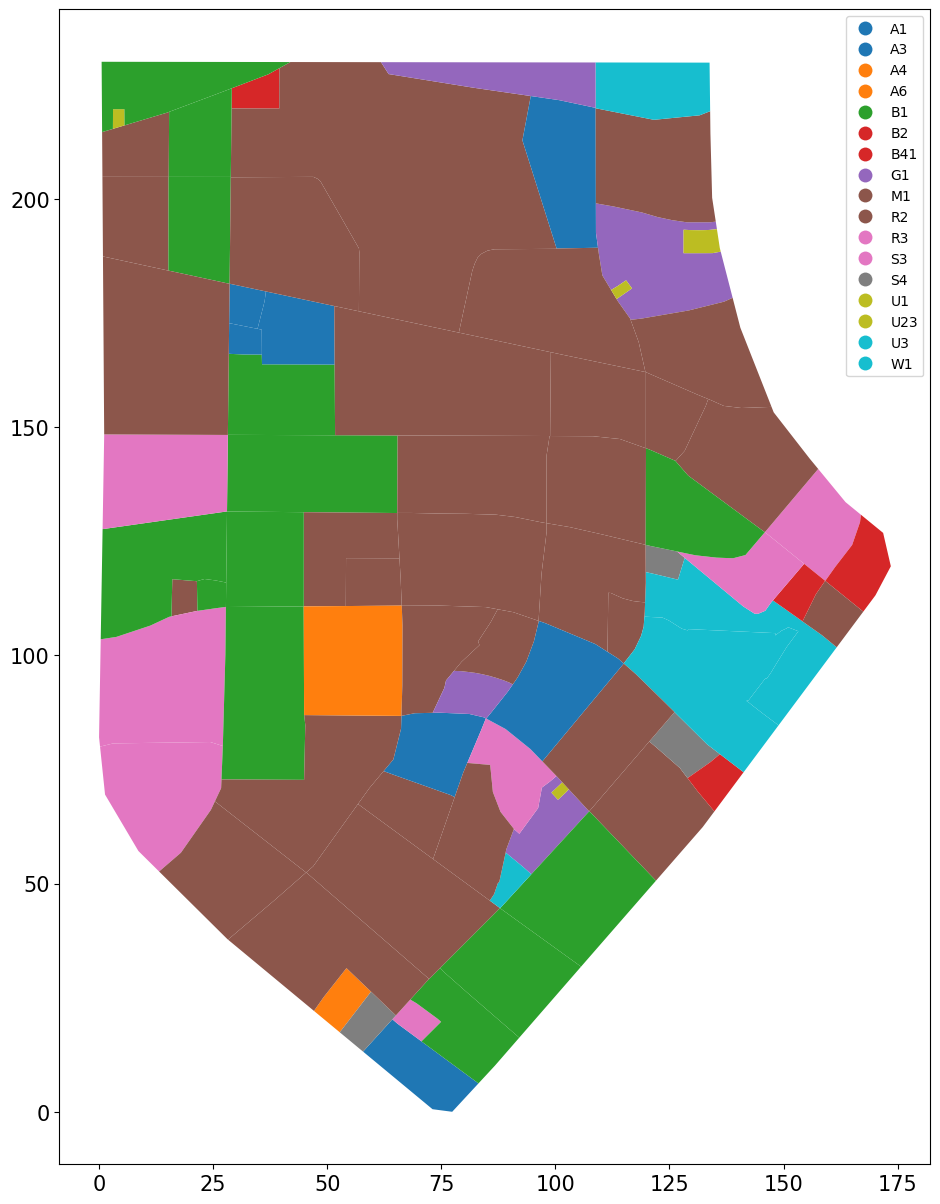

In [13]:
plot_gdf(gdf_land, column='Layer', legend=True, categorical=True)

In [21]:
total_area = gdf_land.unary_union.area
print(total_area)

28881.73582206676


In [18]:
residential_area = gdf_land[(gdf_land['Layer'] == 'R2') | (gdf_land['Layer'] == 'R3')].unary_union.area
print(residential_area/total_area)

0.6137822924116666


In [19]:
with open('./init_plan_huizhou.pickle', 'rb') as f:
    d = pickle.load(f)
    gdf = d['gdf']

In [33]:
gdf[gdf.geom_type=='Polygon'].explore('type', categorical=True)

In [34]:
gdf[gdf.geom_type!='Polygon'].explore('type', categorical=True)

In [22]:
total_area_simplified = gdf.unary_union.area
residential_area_simplified = gdf[gdf['type'] == 4].unary_union.area
feasible_area_simplified = gdf[gdf['type'] == 1].unary_union.area
print(total_area_simplified)
print(residential_area_simplified/total_area_simplified)
print(feasible_area_simplified/total_area_simplified)

28847.0
0.3808194959614518
0.5490692273026658


In [23]:
gdf[gdf['type'] == 4]

type         14
existence    14
geometry     14
dtype: int64

In [52]:
gdf.loc[200, 'geometry'].area

319.0

In [53]:
gdf.loc[24, 'geometry'].length

11.40175425099138

In [31]:
with open('best_reward4.43_iteration_0528.p', 'rb') as f:
    d = pickle.load(f)

In [32]:
gdf = d['best_plans'][0]['gdf']
gdfe = gdf[gdf.existence==True].copy()
land_use_map = {
    0: 0,
    4: 'R2/R3',
    5: 'B1/B2',
    6: 'A1',
    7: 'G',
    8: 'G',
    9: 'A3',
    10: 'S3/S4',
    11: 'S3/S4',
    12: 'U1/U2/U3',
}

gdfe_land = gdfe[gdfe.geom_type=='Polygon'].copy()
gdfe_land['type'] = gdfe_land['type'].apply(lambda x: land_use_map[x])
gdfe_land.loc[239, 'type'] = 'A4'
gdfe_land.loc[214, 'type'] = 'B1/B2'
gdfe_land[gdfe_land.geom_type=='Polygon'].explore('type', categorical=True)

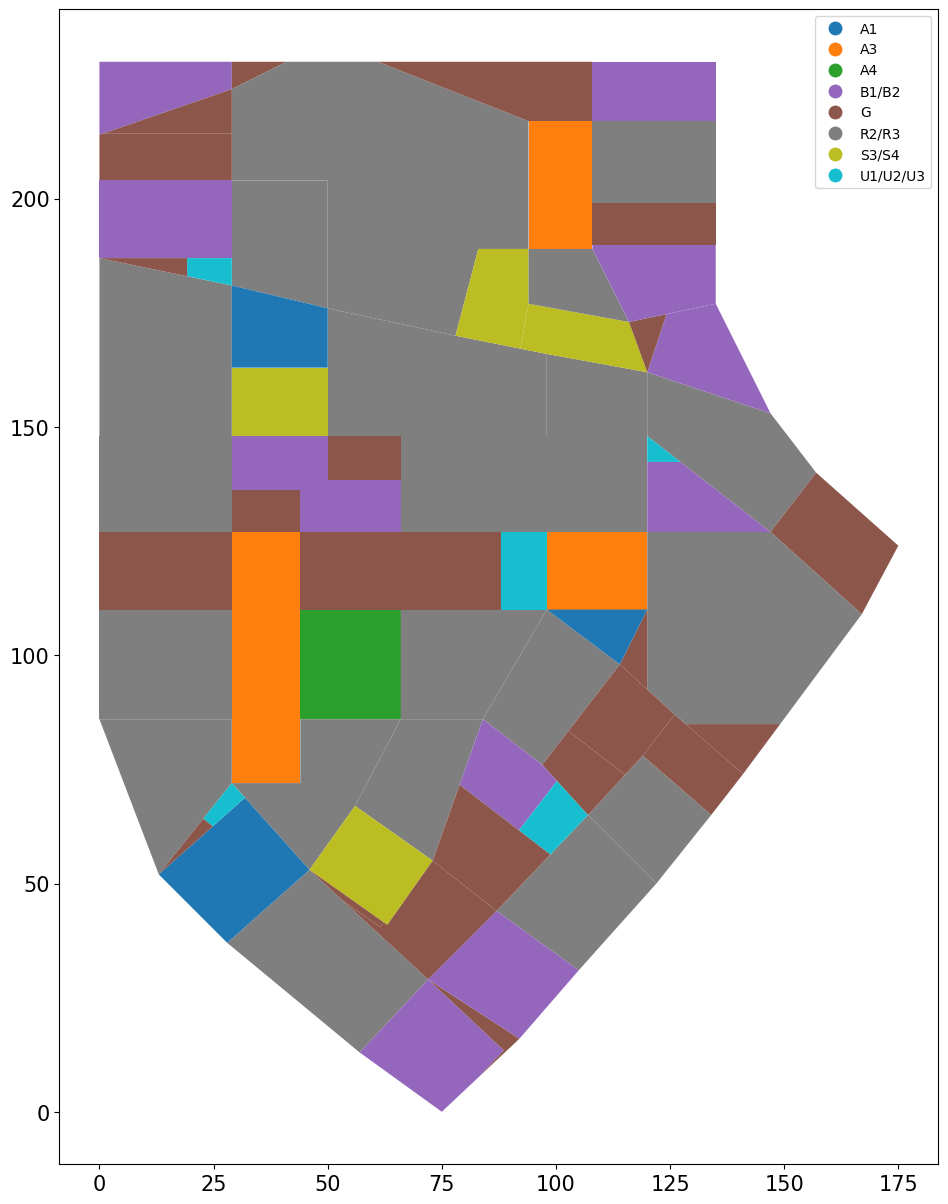

In [33]:
plot_gdf(gdfe_land, column='type', legend=True, categorical=True)

In [35]:
def reverse_translate_and_rescale(gdf, gdf_original):
    scaling_factor = 10.0  # Scale down by a factor of 10
    
    # Create the scaling matrix
    scaling_matrix = [scaling_factor, 0, 0, scaling_factor, 0, 0]
    
    # Apply the scaling transformation to the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: affine_transform(geom, scaling_matrix))
    
    # Get the minimum x and y values from total_bounds
    x_min, y_min, x_max, y_max = gdf_original.total_bounds
    
    # Calculate the translation values
    x_translation = x_min
    y_translation = y_min
    
    # Apply the translation to the GeoDataFrame
    gdf['geometry'] = gdf.translate(xoff=x_translation, yoff=y_translation)
    
    return gdf

In [36]:
gdfe_land = reverse_translate_and_rescale(gdfe_land, gdf_combined)

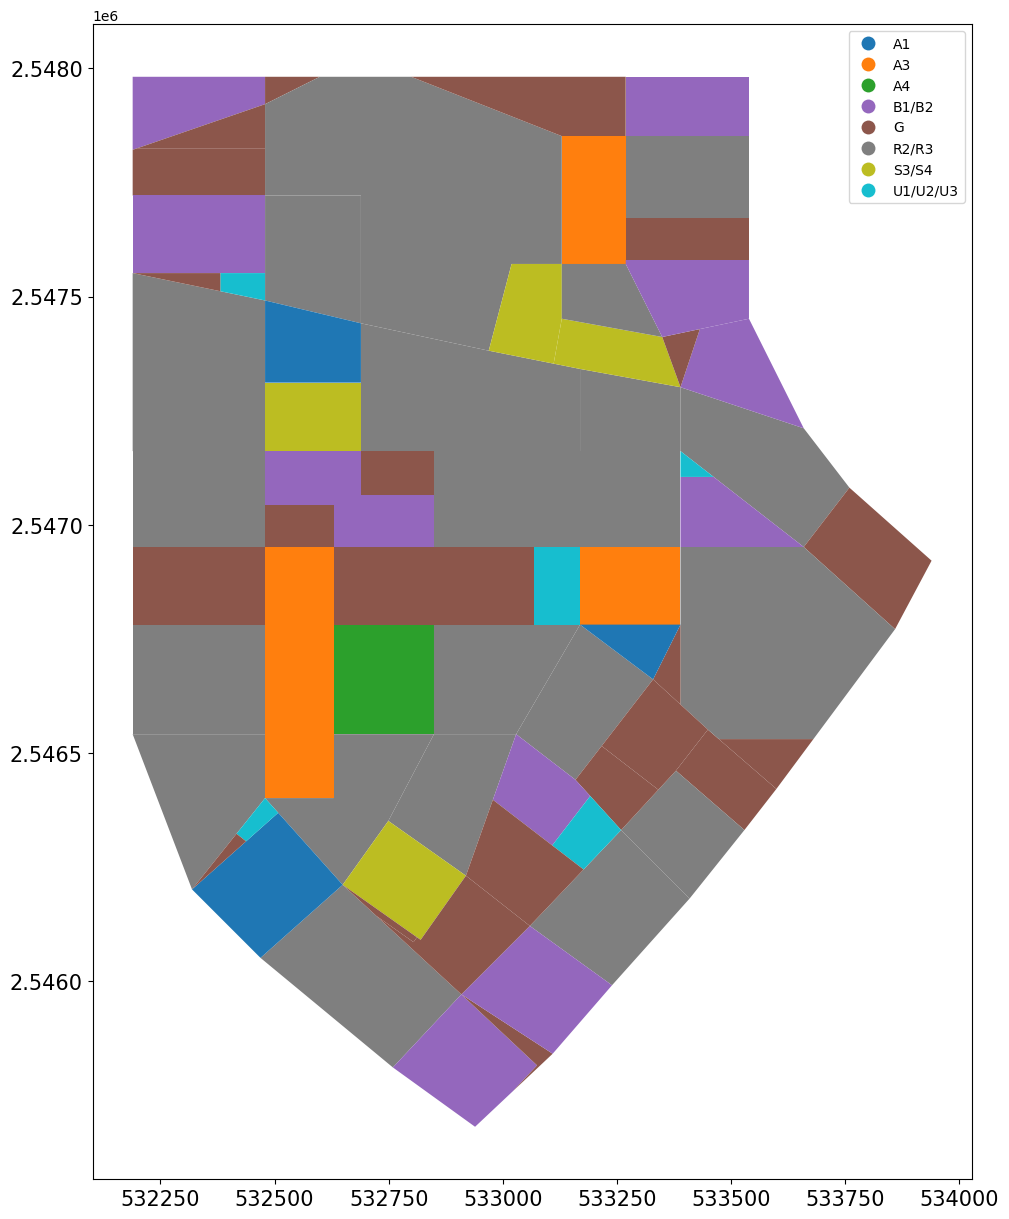

In [37]:
plot_gdf(gdfe_land, column='type', legend=True, categorical=True)

In [15]:
gdfe_land

,type,existence,geometry,rect,eqi,sc
id,,,,,,
0,2,True,"LINESTRING (532189.149 2547981.480, 532189.149...",NaN,NaN,NaN
1,2,True,"LINESTRING (532189.149 2547821.480, 532189.149...",NaN,NaN,NaN
2,2,True,"LINESTRING (532189.149 2547721.480, 532189.149...",NaN,NaN,NaN
3,2,True,"LINESTRING (532189.149 2547551.480, 532189.149...",NaN,NaN,NaN
4,2,True,"LINESTRING (532189.149 2547161.480, 532189.149...",NaN,NaN,NaN
...,...,...,...,...,...,...
454,13,True,POINT (533188.006 2546356.546),NaN,NaN,NaN
455,2,True,"LINESTRING (533160.776 2546366.208, 533188.006...",NaN,NaN,NaN
456,2,True,"LINESTRING (533188.006 2546356.546, 533131.583...",NaN,NaN,NaN


In [38]:
gdfe_land = gdfe_land[['type', 'geometry']]

In [39]:
gdfe_land.to_file('plan3.shp')